# Setup

In [1]:
from data import load_data
from utils import MANUAL_SORT_COLS
from utils import FILTER_VALS

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import catboost as cb
from tqdm import tqdm

import shap
shap.initjs()

In [2]:
TARGET_COLUMNS = ['salary', 'bonus']
TIME_COLUMNS = ['timestamp']

sns.set_theme(style="whitegrid")

In [3]:
def feature_extraction(df, selected_cols=None, dropna=False):

    df = df.copy()  # avoid unexpected side-effects

    # Use a boolean variable to model whether the title has "senior" in it
    df = (
        df
        .assign(
            is_senior=lambda df: df.job_title.str.contains("Senior"),
            job_title_no_senior=lambda df: df.job_title.str.replace("Senior ", ""),
            has_subordinates=lambda df: ~df.num_subordinates.isin([pd.NA, "0"]),
            danish_national=lambda df: df.danish_national.replace(dict(YES=True, NO=False)),
            is_male=lambda df: df.gender.replace(dict(male=True, female=False)),
            received_equity=lambda df: df.received_equity.replace(dict(Yes=True, No=False))
        )
        .drop(columns=TIME_COLUMNS)
        .drop(columns=["job_title", "gender"])
    )

    selected_cols = selected_cols or df.drop(columns=TARGET_COLUMNS).columns.to_list()
    df = df[[c for c in df.columns if c in selected_cols+TARGET_COLUMNS]]

    if dropna:
        df = df.dropna()

    # X = df[selected_cols]
    # y = df[TARGET_COLUMNS]

    return df

# Raw data

In [ ]:
df_raw = load_data(data_dir="../data")
df_raw.head()

# Processing

In [5]:
df = df_raw.copy().replace(to_replace=FILTER_VALS, value=["unknown"]*len(FILTER_VALS))

In [6]:
df = df[
    (df.salary>=35_000)
    & (df.salary<=80_000)
]

In [7]:
df = feature_extraction(df=df, dropna=False)
df = df.drop(columns="tool_usage")
df = df.reset_index(drop=True)

# EDA

In [ ]:
(
    so.Plot(data=df, x="years_experience", y="salary")
    .add(so.Dot(pointsize=3), so.Jitter(y=1_000, x=.5))
    .theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"})
)

In [ ]:
sns.swarmplot(data=df, y="job_title_no_senior", x="salary", size=2)

In [ ]:
sns.swarmplot(data=df, y="sector", x="salary", size=2)

In [ ]:
sns.swarmplot(data=df, y="educational_background", x="salary", size=2)

In [12]:
X = df[[c for c in df.columns if c not in TARGET_COLUMNS]]
y = df["salary"]

X.shape, y.shape

((321, 12), (321,))

# CatBoost leave-1-out modelling

In [ ]:
loo = LeaveOneOut()

predictions = []

for train_index, test_index in tqdm(loo.split(X)):
    train_pool = cb.Pool(
        X.iloc[train_index],
        y.iloc[train_index],
        cat_features=X.select_dtypes(exclude=np.number).columns.to_list()
    )
    test_pool = cb.Pool(
        X.iloc[test_index],
        y.iloc[test_index],
        cat_features=X.select_dtypes(exclude=np.number).columns.to_list()
    )

    model = cb.CatBoostRegressor(
        iterations=100,
        depth=2,
        loss_function='RMSE',
        verbose=False)
    model.fit(train_pool)
    model.predict(test_pool)

    predictions.append(
        pd.merge(
            X.iloc[test_index],
            y.iloc[test_index],
            left_index=True,
            right_index=True
        ).assign(
            prediction=model.predict(test_pool)
        )
    )

predictions = (
    pd.concat(predictions, axis=0)
    .assign(
        delta=lambda df: df.prediction-df.salary,
        error=lambda df: df.delta.abs()
    )
)
predictions.head()

# Model analysis and predictions

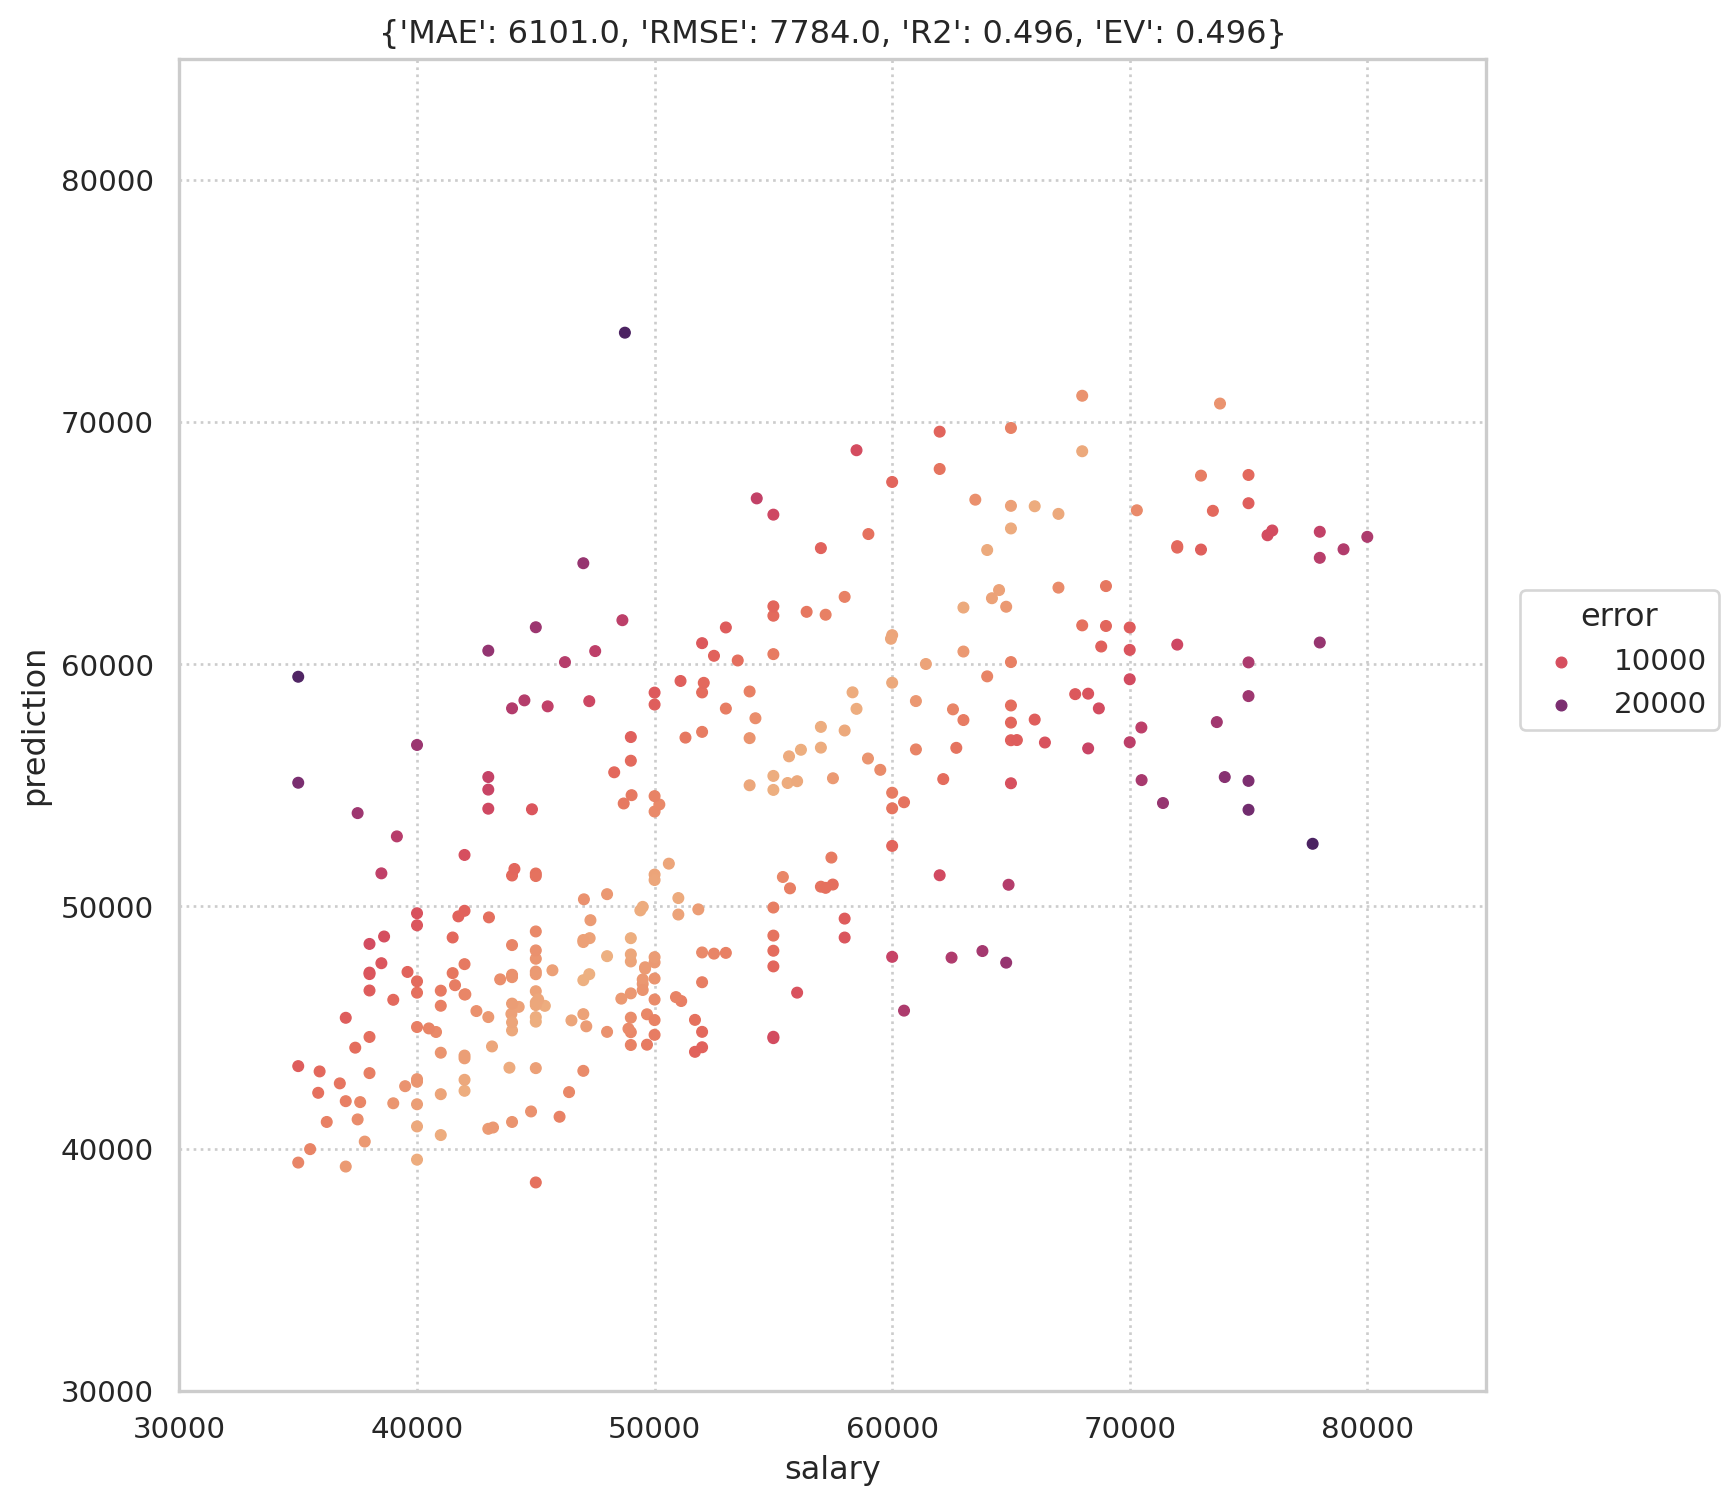

In [14]:
ax_min = pd.concat([predictions.salary, predictions.prediction], axis=0).min() - 5_000
ax_max = pd.concat([predictions.salary, predictions.prediction], axis=0).max() + 5_000

(
    so.Plot(data=predictions, x="salary", y="prediction", color="error")
    .add(so.Dot(pointsize=4))
    .scale(color="flare")
    .limit(x=(ax_min, ax_max), y=(ax_min, ax_max))
    .theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"})
    .layout(size=(8, 8))
    .label(
        title=dict(
            MAE=round(mean_absolute_error(y_true=predictions.salary, y_pred=predictions.prediction),0),
            RMSE=round(mean_squared_error(y_true=predictions.salary, y_pred=predictions.prediction, squared=False),0),
            R2=round(r2_score(y_true=predictions.salary, y_pred=predictions.prediction),3),
            EV=round(explained_variance_score(y_true=predictions.salary, y_pred=predictions.prediction),3),
        )
    )
)

In [ ]:
(
    predictions
    # .pipe(lambda df: df[df.error>10_000])
    # [["salary", "prediction", "error", "years_experience", "is_senior", "job_title_no_senior", "sector", "has_subordinates"]]
    .sort_values("error", ascending=False)
    .round(2)
)

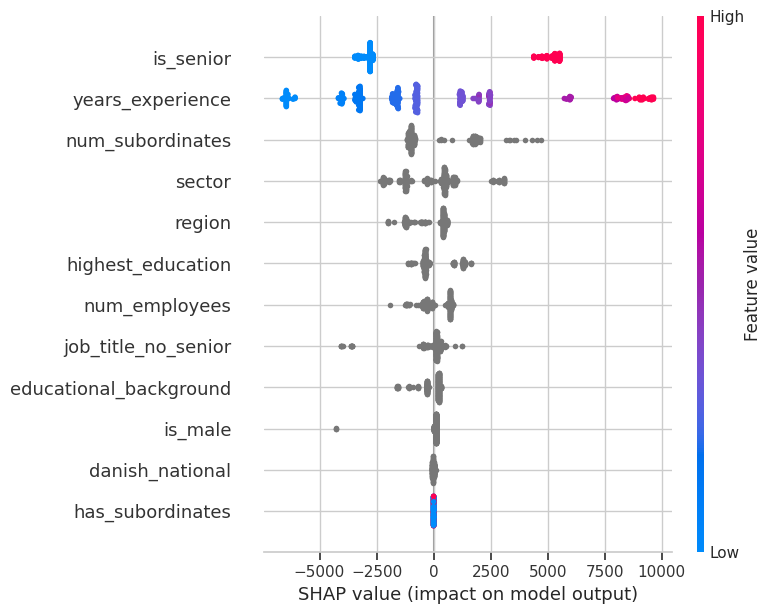

In [16]:
final_pool = cb.Pool(
    predictions.drop(columns=["salary", "prediction", "delta", "error"]),
    predictions["salary"],
    cat_features=X.select_dtypes(exclude=np.number).columns.to_list()
)

model = cb.CatBoostRegressor(
    iterations=100,
    depth=2,
    loss_function='RMSE',
    verbose=False)
model.fit(final_pool)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(final_pool)

shap.summary_plot(shap_values, predictions.drop(columns=["salary", "prediction", "delta", "error"]))

<AxesSubplot:ylabel='feature'>

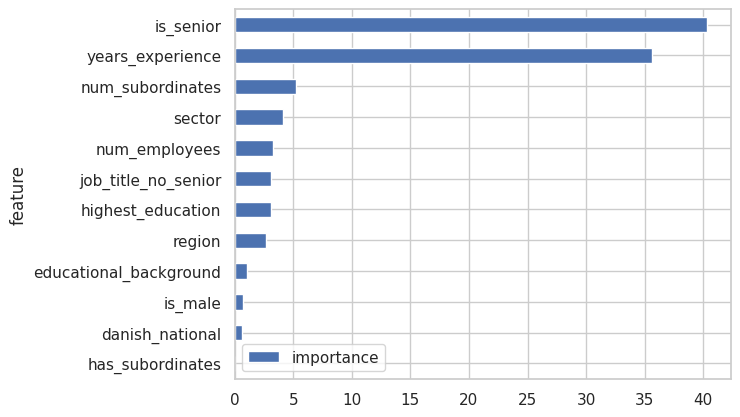

In [17]:
(
    pd.DataFrame(dict(
        importance=model.feature_importances_,
        feature=final_pool.get_feature_names(),
    ))
    .sort_values("importance")
    .plot.barh(y="importance", x="feature")
)

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[0].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[1].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[2].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[3].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[4].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )

In [ ]:
idx = predictions.sort_values("error", ascending=False).iloc[5].name
print(idx)
print(f'actual salary: {predictions.loc[idx, "salary"]:,} DKK')

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    predictions.loc[idx,:].drop(["salary", "prediction", "delta", "error"])
    )